# Get Bi-Annual Pedestrian Counts from NYC

We are going to use the New York City pedestrian count data to verify the feasibility of using CNN for measuring pedestrian volume. For NYC pedestrian data see below:

> An index of pedestrian volumes tracking the long-term trends of neighborhood commercial corridors. Data is collected at 114 locations, including 100 on-street locations (primarily retail corridors), 13 East River and Harlem River bridge locations, and the Hudson River Greenway. Screenline sampling is conducted during May and September on the sidewalk, mid-block (or mid-bridge) on both sides of street where applicable. Pedestrian volumes at 50 sample locations around the City are combined to create the Pedestrian Volume Index for the Mayor’s Management Report. Click here for metadata - http://www.nyc.gov/html/dot/downloads/pdf/bi-annual-ped-count-readme.pdf

> from https://data.cityofnewyork.us/Transportation/Bi-Annual-Pedestrian-Counts/2de2-6x2h/about

## streetscape

I'm going to use my streetscape package to collect google street views. https://github.com/yonghah/streetscape

## import libraries

In [41]:
import os
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import streetscape as ss
from shapely.geometry import Point

%matplotlib inline

## get the dataset from NYC open data

In [8]:
query = ("https://data.cityofnewyork.us/resource/cqsj-cfgu.json")
df = pd.read_json(query)
df.head()

,borough,from_,index,loc,may07_am,may07_d,may07_d2,may07_md,may07_pm,may08_am,...,sept13_md,sept13_pm,sept14_am,sept14_d,sept14_d2,sept14_md,sept14_pm,street,the_geom,to
0,Bronx,West 231st Street,N,1,1189,5/10/2007,5/5/2007,2508,4094,802,...,3008,4590,1450,09/04/14,09/06/14,2996,4646,Broadway,"{'type': 'Point', 'coordinates': [-73.90459140...",Naples Terrace
1,Bronx,Grand Concourse,Y,2,1511,5/10/2007,5/5/2007,1971,3184,1136,...,1832,3890,1949,09/11/14,09/13/14,2388,4435,East 161st Street,"{'type': 'Point', 'coordinates': [-73.92188432...",Sheridan Avenue
2,Bronx,Valentine Avenue,Y,3,1832,5/10/2007,5/5/2007,14391,12311,1061,...,8241,10613,2752,09/04/14,09/06/14,8266,10408,East Fordham Road,"{'type': 'Point', 'coordinates': [-73.89535781...",Tiebout Avenue
3,Bronx,Bainbridge Avenue,N,4,764,5/10/2007,5/5/2007,1798,2673,2102,...,1914,3660,2382,09/04/14,09/06/14,1339,3425,East Gun Hill Road,"{'type': 'Point', 'coordinates': [-73.87892467...",Rochambeau Avenue
4,Bronx,Prospect Avenue,N,5,650,5/10/2007,5/5/2007,2334,2538,553,...,2805,3488,1019,09/04/14,09/06/14,2366,3184,East Tremont Avenue,"{'type': 'Point', 'coordinates': [-73.88956389...",Clinton Avenue


### convert json geometry to geopandas geometry
This dataset's geometry is json format. Let's convert this to geopandas geoseries (shapely format) to utilize streetscape's get_street_views_from_df function.

In [20]:
df['geom_gpd']  = df['the_geom'].apply(lambda r: Point(r['coordinates']))

In [22]:
df.head()

,borough,from_,index,loc,may07_am,may07_d,may07_d2,may07_md,may07_pm,may08_am,...,sept13_pm,sept14_am,sept14_d,sept14_d2,sept14_md,sept14_pm,street,the_geom,to,geom_gpd
0,Bronx,West 231st Street,N,1,1189,5/10/2007,5/5/2007,2508,4094,802,...,4590,1450,09/04/14,09/06/14,2996,4646,Broadway,"{'type': 'Point', 'coordinates': [-73.90459140...",Naples Terrace,POINT (-73.90459140730687 40.87919896648575)
1,Bronx,Grand Concourse,Y,2,1511,5/10/2007,5/5/2007,1971,3184,1136,...,3890,1949,09/11/14,09/13/14,2388,4435,East 161st Street,"{'type': 'Point', 'coordinates': [-73.92188432...",Sheridan Avenue,POINT (-73.92188432870225 40.82662794123293)
2,Bronx,Valentine Avenue,Y,3,1832,5/10/2007,5/5/2007,14391,12311,1061,...,10613,2752,09/04/14,09/06/14,8266,10408,East Fordham Road,"{'type': 'Point', 'coordinates': [-73.89535781...",Tiebout Avenue,POINT (-73.89535781584343 40.86215460031516)
3,Bronx,Bainbridge Avenue,N,4,764,5/10/2007,5/5/2007,1798,2673,2102,...,3660,2382,09/04/14,09/06/14,1339,3425,East Gun Hill Road,"{'type': 'Point', 'coordinates': [-73.87892467...",Rochambeau Avenue,POINT (-73.87892467324485 40.8812869959873)
4,Bronx,Prospect Avenue,N,5,650,5/10/2007,5/5/2007,2334,2538,553,...,3488,1019,09/04/14,09/06/14,2366,3184,East Tremont Avenue,"{'type': 'Point', 'coordinates': [-73.88956389...",Clinton Avenue,POINT (-73.88956389732796 40.84463677671767)


### get street view images
18 images per one location (FOV=20) with 2 degree overlap

In [40]:
image_dir = '../data/raw/streetview-nyc'
df_test = df.head(2)
ss.get_street_views_from_df(
    df_test,
    save_dir = image_dir,
    geom='geom_gpd',
    pic_per_obs=18,
    pad=2) 

### check images

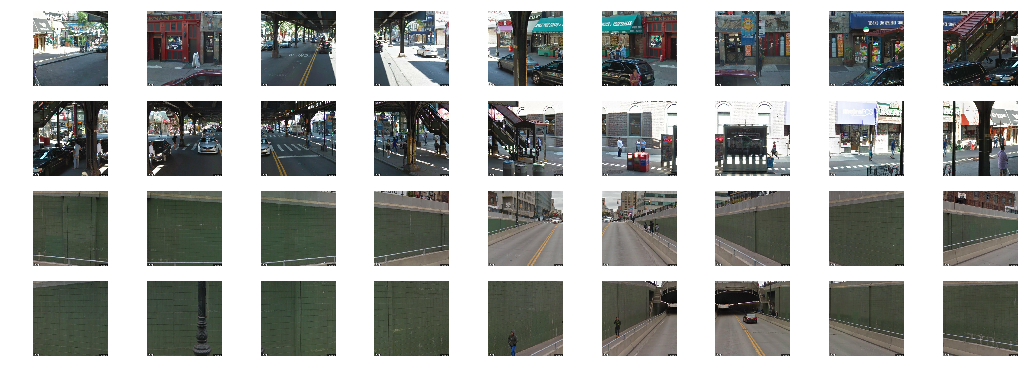

In [42]:
# look at images
images = []
for img_path in sorted(glob.glob(image_dir+'/*.jpg'), key=os.path.getmtime):
    images.append(mpimg.imread(img_path))
    
plt.figure(figsize=(18,8))
columns = 9
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)